<a href="https://colab.research.google.com/github/Tarek-Mahm0ud/RNN-Ptoject---time_serial/blob/main/TaskRNNtarek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sample data:

--
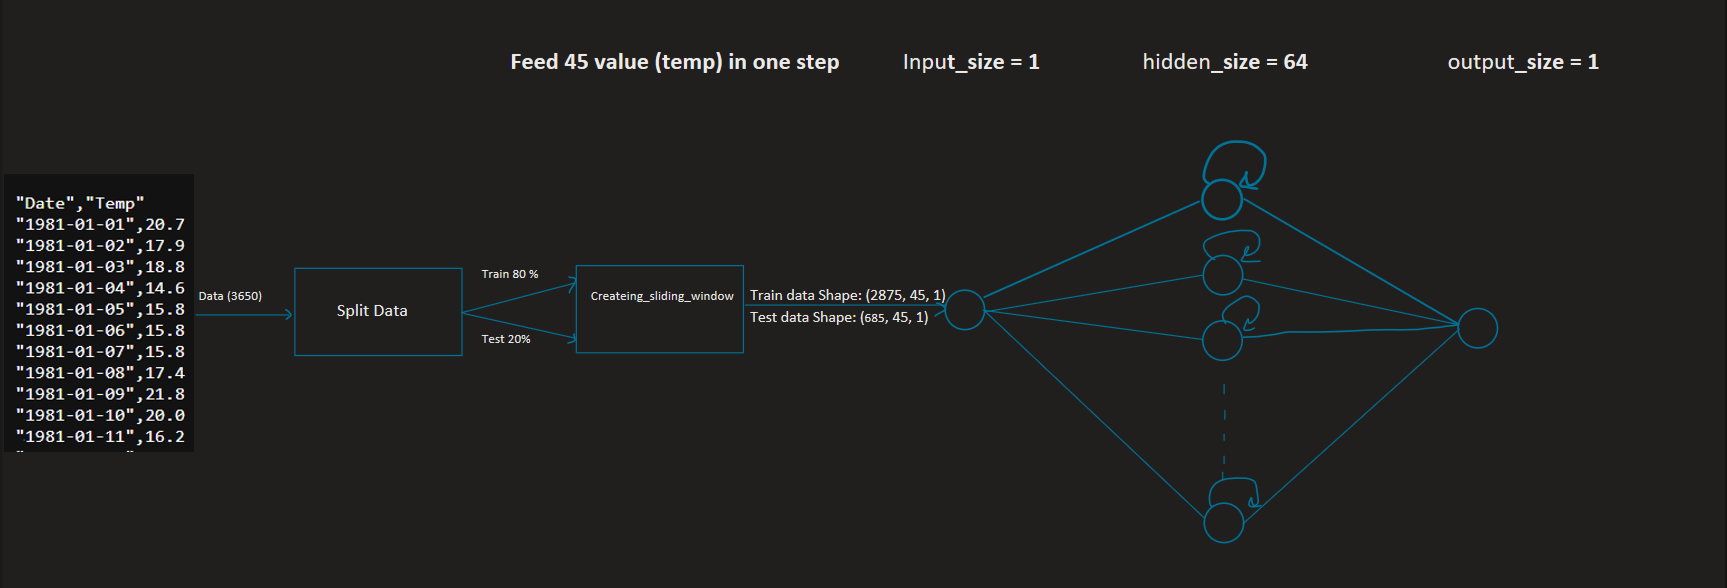

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [84]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url)
data = df['Temp'].values.reshape(-1, 1)

print(f"Dataset Loaded. Total days: {len(data)}")

Dataset Loaded. Total days: 3650


In [85]:
def create_sliding_windows(data, seq_length):
    len_data = len(data)
    x = [data[i : i + seq_length] for i in range(len_data - seq_length)]
    y = [data[i + seq_length] for i in range(len_data - seq_length)]

    return (torch.tensor(np.array(x), dtype=torch.float32),
            torch.tensor(np.array(y), dtype=torch.float32))

train_size = int(len(data) * 0.8)
train_raw = data[:train_size]
test_raw = data[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train_raw)
test_norm = scaler.transform(test_raw)

SEQ_LENGTH = 45
input_data, target = create_sliding_windows(train_norm, SEQ_LENGTH)
test_input, test_target = create_sliding_windows(test_norm, SEQ_LENGTH)

print(f"Training Input Shape: {input_data.shape}")
print(f"Test Input Shape:     {test_input.shape}")

Training Input Shape: torch.Size([2875, 45, 1])
Test Input Shape:     torch.Size([685, 45, 1])


In [86]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True) #(Batch, Seq, Feature)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)#out, hidden_state

        last_time_step = out[:, -1, :]

        prediction = self.fc(last_time_step)
        return prediction

model = SimpleRNN(input_size=1, hidden_size=64, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [87]:
epochs = 300
for epoch in range(epochs):
    model.train()

    # Forward pass
    outputs = model(input_data)
    loss = criterion(outputs, target)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}")

print("Training Complete.")

Epoch 50
Epoch 100
Epoch 150
Epoch 200
Epoch 250
Epoch 300
Training Complete.


Mean Absolute Error: 1.75 °C
R² Score: 0.7008
Accuracy: 82.48%


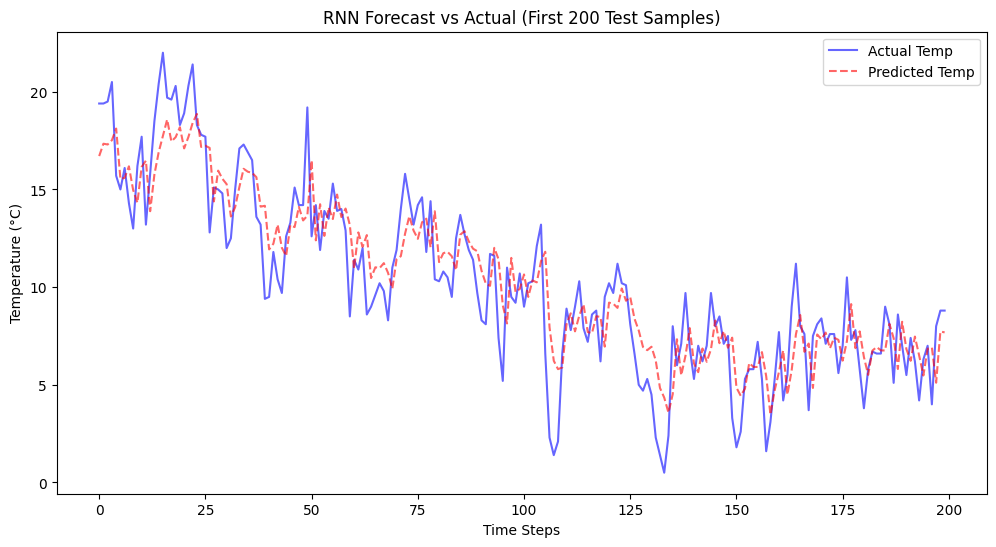

In [88]:
model.eval()
with torch.no_grad():
    predicted_tensor = model(test_input)

predictions_c = scaler.inverse_transform(predicted_tensor.cpu().numpy())
actuals_c = scaler.inverse_transform(test_target.cpu().numpy())

mae = mean_absolute_error(actuals_c, predictions_c)
r2 = r2_score(actuals_c, predictions_c)

print(f"Mean Absolute Error: {mae:.2f} °C")
print(f"R² Score: {r2:.4f}")

threshold = 3
correct_predictions = np.abs(predictions_c - actuals_c) <= threshold
accuracy_custom = np.mean(correct_predictions) * 100
print(f"Accuracy: {accuracy_custom:.2f}%")


plt.figure(figsize=(12, 6))
limit = 200
plt.plot(actuals_c[:limit], label='Actual Temp', color='blue', alpha=0.6)
plt.plot(predictions_c[:limit], label='Predicted Temp', color='red', alpha=0.6, linestyle='--')
plt.title(f'RNN Forecast vs Actual (First {limit} Test Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()